#### **This test for feature importance**

In [1]:
import pandas as pd
# import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

import importlib

#### packages
import helper.visualization as viz_hp
import config.config as config_hp

import copy
# import helper.stat_helper as stat_hp

Source: https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660

Default impurity based feature importance based on mean decrease in impurity (Gini importance), which measures how effective each feature is at reducing uncertainty.
Overfit model gives wrong interpretation for feature importance.

Ways to reduce overfitting:
- Regularization (min_samples_leaf)

Ways to get feature importance:
- **Permutation importance** (Train the baseline model and record the score (accuracy) on the validation set. Re-shuffle the values for one features, use the model to predict again, and calculate scores on the validation set. The feature importance for the feature is the difference between the baseline and permutation score, repeating the process for all features)
that permutation importances computed on a random forest model spread importance across collinear variables. The amount of sharing appears to be a function of how much noise there is between the two.
- **Drop column importance**  (calculate the model performance with all perdictors and drop a single predictor and see the reduction in the performane, the more important the feature is, the larger the decrease we see in the model performances)

Challenges of feature importance: correlation

#### **Run the model**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [3]:
def tuned_model(X,y):
    '''
    Trains the model and run cross validation
    :param X: features
    :param y: target
    
    '''
    from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

    # Creating a dictionary of scorers
    scoring = {
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }

    cv_scores = [
        "train_precision",
        "test_precision",
        "train_recall",
        "test_recall",
        "train_f1",
        "test_f1",
        "train_roc_auc",
        "test_roc_auc",
    ]

    from sklearn.model_selection import TunedThresholdClassifierCV
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.metrics import f1_score

    model = RandomForestClassifier(n_estimators=100, 
                                   random_state=42
                                  )
    
    model = make_pipeline(StandardScaler(), model)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
    tuned_model = TunedThresholdClassifierCV(estimator=model,
                                             scoring='f1',
                                             store_cv_results = True,
                                             n_jobs=-1
                                            )

    cv_results_tuned_model = pd.DataFrame(
        cross_validate(
            tuned_model,
            X,
            y,
            scoring=scoring,
            cv=cv,
            return_train_score=True,
            return_estimator=True,
        )
    )
   
    from sklearn.metrics import f1_score

    decision_threshold = pd.Series(
        [est.best_threshold_ for est in cv_results_tuned_model["estimator"]],
    )
    cv_results_tuned_model['threshold'] = decision_threshold
    
    cv_results_tuned_model['algorithm'] = 'random_forest'
    
    return cv_results_tuned_model[['test_f1']].mean()

In [4]:
def run_model(df, 
              columns_not_include,
              y_column = 'replier_label'
             ):
    
    columns_not_include.extend(
        ['poster_tweetid',
         'tweet_label',
         'replier_userid',
         'replier_label']
    )
    
    columns_to_keep = list(set(df.columns) - set(columns_not_include))
    
    df_1 = df.loc[df['replier_label'] == 1]
    df_0 = df.loc[df['replier_label'] == 0]

    df_row = df_0.sample(n=len(df_1))
    df_all = df_1.append(df_row)
    
    X = df_all[columns_to_keep]
    y = df_all[y_column]
    
    return tuned_model(X,y), columns_to_keep
    

In [5]:
all_feature = './../data/RQ3_replier_classifier_features.csv'

df_stat = pd.read_csv(all_feature)

#### **Train**

In [6]:
best_score, columns_to_keep = run_model(df_stat, 
                           columns_not_include=[]
                          )

/tmp/ipykernel_1784042/2179666833.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_1.append(df_row)
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [7]:
best_score

test_f1    0.905554
dtype: float64

#### **Run Feature Importance**

In [8]:
columns_to_keep = list(df_stat.columns)

diff_features = {'Delay': 'diff_min',
                 
                 'Reply_level_like': 'like_count',
                 'Reply_level_retweet':'retweet_count',
                 'Reply_level_reply':'reply_count',
                 
                 'Similarity': 'cosine',
                 
                 'Entites_mention': 'mention',
                 'Entites_hashtags': 'hashtags',
                 'Entites_url': 'url',
                 
                 'Followers rate': 'followers_ratio',
                 'Following rate': 'following_ratio',
                 'Activity rate': 'activity_rate',
                 'Age': 'age'
                }

print('Running the model')

import copy

grp_feat = {}
for feature in diff_features:
    print(f'Removing the feature {feature}')
    
    feat = diff_features[feature]
    matching_test = [col for col in columns_to_keep if feat in col]
    grp_feat[feature] = matching_test

Running the model
Removing the feature Delay
Removing the feature Reply_level_like
Removing the feature Reply_level_retweet
Removing the feature Reply_level_reply
Removing the feature Similarity
Removing the feature Entites_mention
Removing the feature Entites_hashtags
Removing the feature Entites_url
Removing the feature Followers rate
Removing the feature Following rate
Removing the feature Activity rate
Removing the feature Age


In [9]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

def permutation_importance_group(base_best_score,
                                 X, y, 
                                 feature_groups, 
                                 scoring=f1_score
                                ):
    
    mean_1 = base_best_score
    importances = {}
    
    for group_name, group_features in feature_groups.items():
        print(f'****Starting for {group_name} ****') 
        
        each_score = []
        for i in range(0,10):
            all_score = []
            X_valid_shuffled = X.copy()
            for feature in group_features:
                X_valid_shuffled[feature] = np.random.permutation(
                    X_valid_shuffled[feature]
                )

            feat_score = tuned_model(X_valid_shuffled, y)
            
            all_score.extend(feat_score)
            
            decrease = mean_1 - np.mean(np.array(all_score))
            
            each_score.append(decrease)
                
        importances[group_name] = each_score
    
    return importances

In [10]:
def plot_permutation_importance(base_best_score,
                                X, 
                                y, 
                                feature_groups=grp_feat,
                               ):
    results = permutation_importance_group(base_best_score,
                                           X, y, 
                                           feature_groups, 
                                           scoring=f1_score
                                          )
    print(results)
    
    return results

In [11]:
columns_not_include = ['poster_tweetid','tweet_label', 
                       'replier_userid', 'replier_label'
                      ]
columns_to_keep = list(set(df_stat.columns) - set(columns_not_include))

df_1 = df_stat.loc[df_stat['replier_label'] == 1]
df_0 = df_stat.loc[df_stat['replier_label'] == 0]

df_row = df_0.sample(n=len(df_1))
df_all = df_1.append(df_row)

X = df_all[columns_to_keep]
y = df_all['replier_label']

results = plot_permutation_importance(
    best_score,
    X, y, 
    feature_groups=grp_feat
)

/tmp/ipykernel_1784042/2031931954.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_1.append(df_row)
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


****Starting for Delay ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Reply_level_like ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Reply_level_retweet ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Reply_level_reply ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Similarity ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Entites_mention ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Entites_hashtags ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Entites_url ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Followers rate ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Following rate ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Activity rate ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

****Starting for Age ****


/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/potem/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/N/slate/pote

{'Delay': [test_f1    0.000405
dtype: float64, test_f1    0.00162
dtype: float64, test_f1    0.00259
dtype: float64, test_f1    0.00131
dtype: float64, test_f1   -0.000436
dtype: float64, test_f1    0.003049
dtype: float64, test_f1    0.005463
dtype: float64, test_f1    0.000817
dtype: float64, test_f1   -0.000131
dtype: float64, test_f1    0.002058
dtype: float64], 'Reply_level_like': [test_f1   -0.000908
dtype: float64, test_f1    0.002415
dtype: float64, test_f1    0.001046
dtype: float64, test_f1    0.000851
dtype: float64, test_f1    0.001257
dtype: float64, test_f1    0.000341
dtype: float64, test_f1    0.000304
dtype: float64, test_f1   -0.001648
dtype: float64, test_f1    0.001416
dtype: float64, test_f1   -0.000933
dtype: float64], 'Reply_level_retweet': [test_f1   -0.001275
dtype: float64, test_f1   -0.000872
dtype: float64, test_f1   -0.002716
dtype: float64, test_f1    0.000875
dtype: float64, test_f1   -0.003775
dtype: float64, test_f1   -0.00469
dtype: float64, test_f1   

In [12]:
# results
all_data = {}
for key in results:
    print(key)
    all_data[key] = [ x.values[0] for x in results[key]]
    
df_test_imp  = pd.DataFrame()

for key in all_data:
    df_test_imp[key] = all_data[key]
    

df_test_imp.to_pickle('./../results/replier_model_permutation_test.pkl.gz')

Delay
Reply_level_like
Reply_level_retweet
Reply_level_reply
Similarity
Entites_mention
Entites_hashtags
Entites_url
Followers rate
Following rate
Activity rate
Age


In [2]:
import pandas as pd

df_test_imp = pd.read_pickle(
    './../results/replier_model_permutation_test.pkl.gz'
)
# df_test_imp
all_data = {}
for col in df_test_imp.columns:
    all_data[col] = df_test_imp[col].tolist()

In [7]:
# all_data

#### **Plot the features**

In [3]:
def assign_color(org_labels):
    colors = {'Delay': 'red', 
              
              'Entities_mention': 'blue', 
              'Entities_hashtags': 'blue', 
              'Entities_url': 'blue', 
              
              'Similarity': 'teal', 
              
              'Reply_level_reply': 'purple',
              'Reply_level_like': 'purple',
              'Reply_level_retweet': 'purple',
              
              'Followers rate': 'green', 
              'Following rate': 'black', 
              'Activity rate': 'orange', 
              'Age': 'yellow'
             }
    
    legends = {'Delay': 'Delay', 
              
              'Entities_mention': 'Entities', 
              'Entities_hashtags': 'Entities', 
              'Entities_url': 'Entities', 
              
              'Similarity': 'Similarity', 
              
              'Reply_level_reply': 'Engagement',
              'Reply_level_like': 'Engagement',
              'Reply_level_retweet': 'Engagement',
              
              'Followers rate': 'Follower_rate', 
              'Following rate': 'Following_rate', 
              'Activity rate': 'Activity_rate', 
              'Age': 'Age'
             }

    all_colors = {}
    for column in org_labels:
        for keys in colors:
            if column == 'Entites_mention':
                column = 'Entities_mention'
            if column == 'Entites_hashtags':
                column = 'Entities_hashtags'
            if column == 'Entites_url':
                column = 'Entities_url'
            if column == keys:
                all_colors[column] = colors[keys]
    
    return all_colors, legends

In [4]:
def plot_feature_importance(features_score,
                           ax
                           ):
    all_score = []
    org_labels = []
    sort_index = []
    for feat in features_score:
        all_score.append([round(x, 3) for x in features_score[feat]])
        sort_index.append(np.mean(np.array(features_score[feat])))
        org_labels.append(feat)
    index = np.argsort(sort_index)
    labels = [org_labels[i] for i in index]
    labels_colors, legends = assign_color(labels)
    scores = [all_score[i] for i in index]
    
    print(labels_colors)
    
    plots = []
    plot = ax.boxplot(
        scores,
        vert=False,
        labels=labels,
        patch_artist=True
        # color=colors,
        # fontsize=30
    )

    plots.append(plot)
    
    print(labels_colors)
    
    colors = [labels_colors[x] for x in labels]
    index_legends  = [legends[x] for x in labels]
    
    print(colors)
    print(index_legends)
    
    for i, plot in enumerate(plots):
        legend_box = []
        color_test = []
        sel_names = []
        for k, box in enumerate(plot['boxes']):
            box.set(color = colors[k],
                    linewidth=1)
            if colors[k] in color_test:
                continue
            else:
                legend_box.append(box)
                color_test.append(colors[k])
                sel_names.append(index_legends[k])

        ax.legend(legend_box, sel_names, fontsize=24)

    ax.axvline(x=0, color="k", linestyle="--")

    return ax, org_labels

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
all_data.keys()

dict_keys(['Delay', 'Reply_level_like', 'Reply_level_retweet', 'Reply_level_reply', 'Similarity', 'Entites_mention', 'Entites_hashtags', 'Entites_url', 'Followers rate', 'Following rate', 'Activity rate', 'Age'])

In [7]:
def change_key_name(d, old_key, new_key):
    if old_key in d:
        d[new_key] = d.pop(old_key)
    else:
        print(f"Key '{old_key}' not found in the dictionary.")

change_key_name(all_data, 'Entites_mention',  'Entities_mention')
change_key_name(all_data, 'Entites_url',      'Entities_url')
change_key_name(all_data, 'Entites_hashtags', 'Entities_hashtags')

print(all_data.keys())


dict_keys(['Delay', 'Reply_level_like', 'Reply_level_retweet', 'Reply_level_reply', 'Similarity', 'Followers rate', 'Following rate', 'Activity rate', 'Age', 'Entities_mention', 'Entities_url', 'Entities_hashtags'])


{'Age': 'yellow', 'Entities_url': 'blue', 'Following rate': 'black', 'Entities_mention': 'blue', 'Reply_level_retweet': 'purple', 'Reply_level_reply': 'purple', 'Followers rate': 'green', 'Entities_hashtags': 'blue', 'Reply_level_like': 'purple', 'Delay': 'red', 'Activity rate': 'orange', 'Similarity': 'teal'}
{'Age': 'yellow', 'Entities_url': 'blue', 'Following rate': 'black', 'Entities_mention': 'blue', 'Reply_level_retweet': 'purple', 'Reply_level_reply': 'purple', 'Followers rate': 'green', 'Entities_hashtags': 'blue', 'Reply_level_like': 'purple', 'Delay': 'red', 'Activity rate': 'orange', 'Similarity': 'teal'}
['yellow', 'blue', 'black', 'blue', 'purple', 'purple', 'green', 'blue', 'purple', 'red', 'orange', 'teal']
['Age', 'Entities', 'Following_rate', 'Entities', 'Engagement', 'Engagement', 'Follower_rate', 'Entities', 'Engagement', 'Delay', 'Activity_rate', 'Similarity']


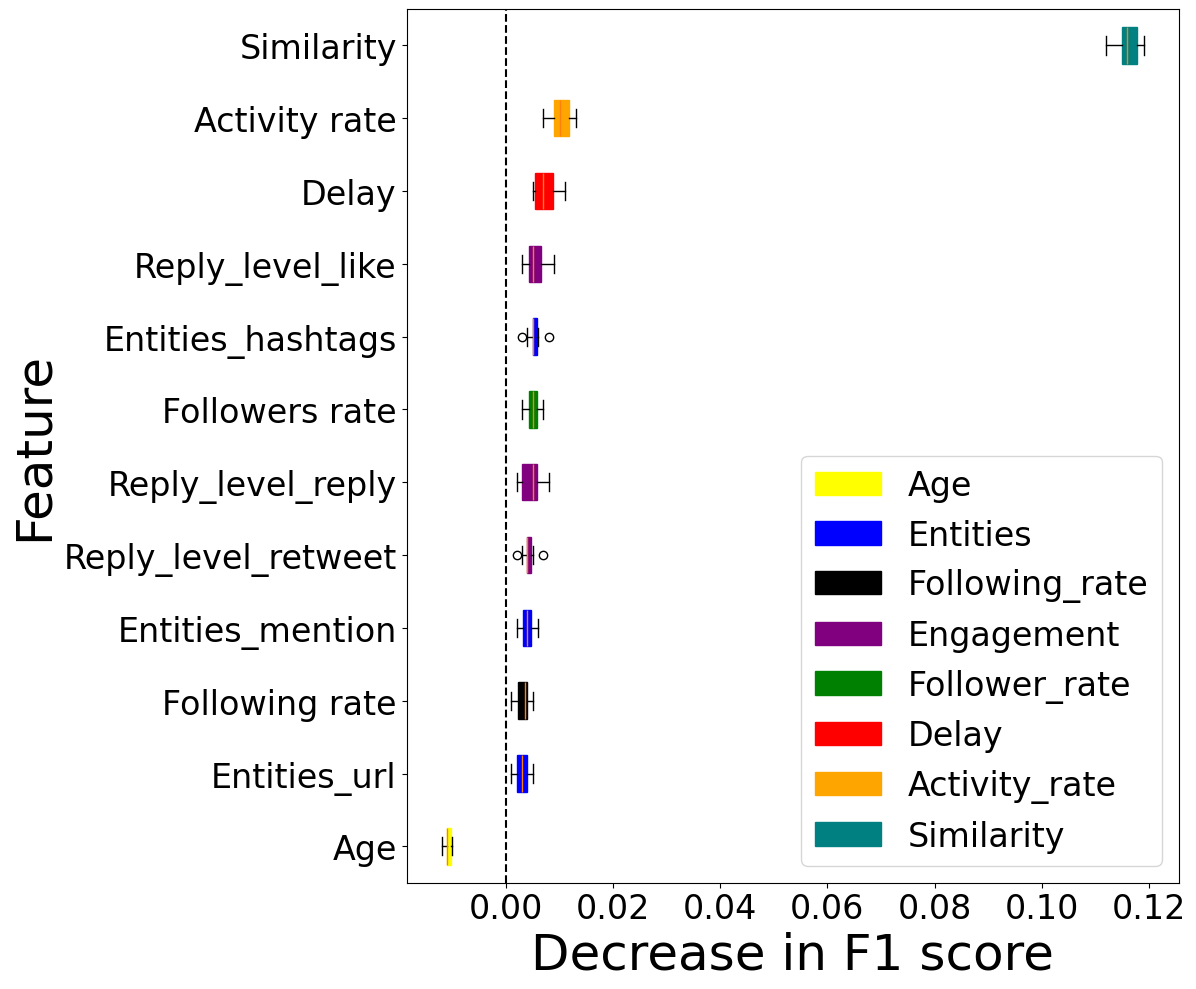

In [9]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 10))

ax, labels = plot_feature_importance(all_data,
                           ax
                           )

ax.set_xlabel("Decrease in F1 score", fontsize=36)
ax.set_ylabel("Feature", fontsize=36)

plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

ax.figure.tight_layout()

fig.savefig(f'./../plots/replier_feat_importance_grp_threshold_fix.png', 
      facecolor='white', 
      transparent=False
           )
plt.show()